In [2]:
!pip install PyDrive

    100% |████████████████████████████████| 993kB 19.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
pwd

'/content'

In [0]:
download = drive.CreateFile({'id':'1t19mxKOrFgePTGOvoCyaB-bj4EguQ4Cq'})

In [0]:
download.GetContentFile('train-scene-classification.zip')
!unzip train-scene-classification.zip

In [0]:
mkdir data-test

In [9]:
cd data-test

/content/data-test


In [0]:
mkdir test_imgs

In [15]:
cd test_imgs

[Errno 2] No such file or directory: 'test_imgs'
/content/data-test/test_imgs


In [0]:
import os
import errno
import shutil
import pandas as pd

IMAGES ='/content/train'
DIR = '/content/data-test/test_imgs'


# Import training labels
data1 = pd.read_csv('test.csv')

# Moving files in respective directories
for images in data1['image_name']:
    shutil.move(IMAGES+'/'+images, DIR+'/'+images)

In [18]:
cd /..

/


In [19]:
cd content

/content


In [0]:
download = drive.CreateFile({'id':'1t19mxKOrFgePTGOvoCyaB-bj4EguQ4Cq'})
download.GetContentFile('train-scene-classification.zip')
!unzip train-scene-classification.zip

In [20]:
ls

adc.json    sample_data/  train/     train-scene-classification.zip
data-test/  test.csv      train.csv


In [0]:
mkdir models

In [0]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

In [23]:
train_path='/content/'
test_path='/content/'
df = pd.read_csv('train.csv')
df['label'].value_counts()
#Classes to be predicted
# buildings-0,forest-1,glacier-2,mountain-3,sea-4,street-5

3    3037
2    2957
5    2883
4    2784
1    2745
0    2628
Name: label, dtype: int64

In [24]:
df.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [0]:

from fastai import *
from fastai.vision import *

In [0]:

path='/content/train/'

In [0]:
tfms = get_transforms(flip_vert=False,max_zoom=1.0,max_warp=0.5)
data = (ImageList.from_csv(path, csv_name = '/content/train.csv') 
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = '/content/data-test/test_imgs')              
        .transform(tfms, size=128)
        .databunch(num_workers=0))

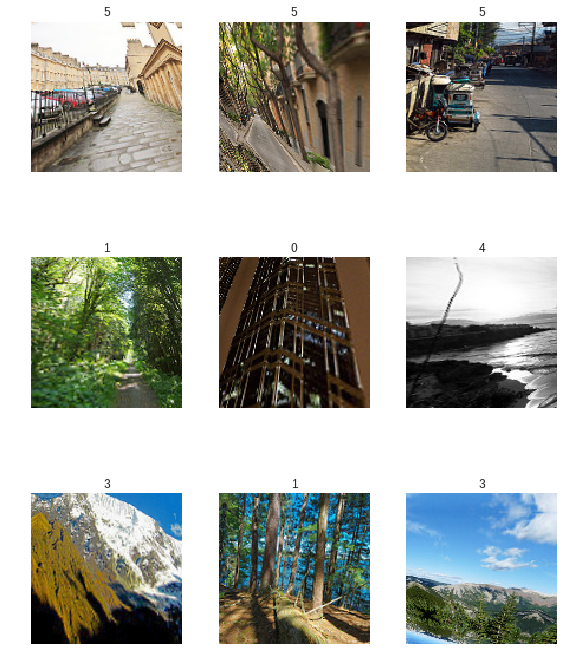

In [28]:
data.show_batch(rows=3, figsize=(8,10))

In [29]:
print(data.classes)

[0, 1, 2, 3, 4, 5]


In [30]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy], model_dir="/content/models/")


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 80890206.15it/s]


In [31]:
learn.fit_one_cycle(4)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.617998,0.321903,0.118614,0.881386,01:54
1,0.443273,0.262326,0.097475,0.902525,01:51
2,0.360621,0.240666,0.086905,0.913095,01:51
3,0.335112,0.233311,0.086318,0.913682,01:51


In [0]:
learn.save('/content/models/stage-1-34-128')

In [35]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

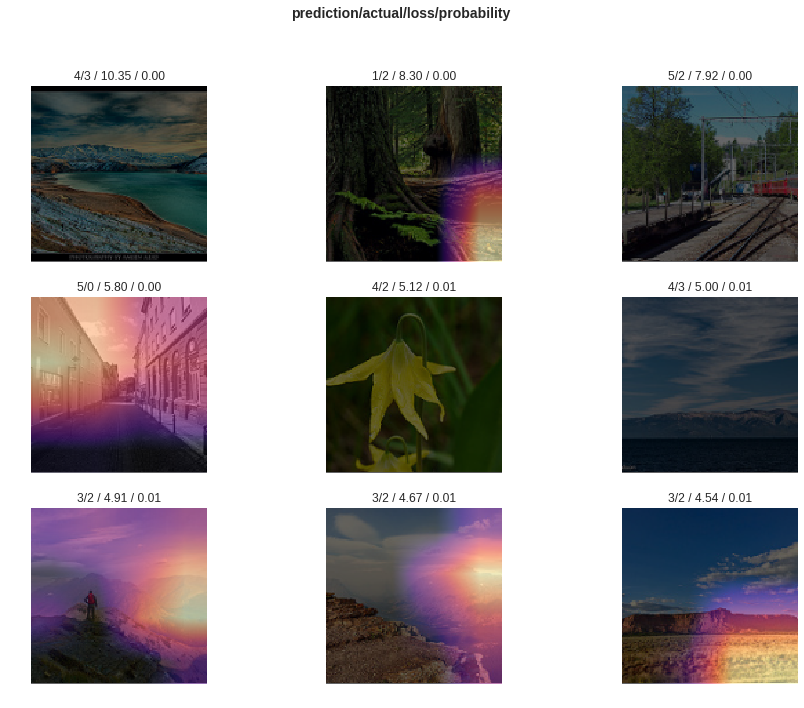

In [36]:
interp.plot_top_losses(9, figsize=(15,11))

In [37]:
doc(interp.plot_top_losses)

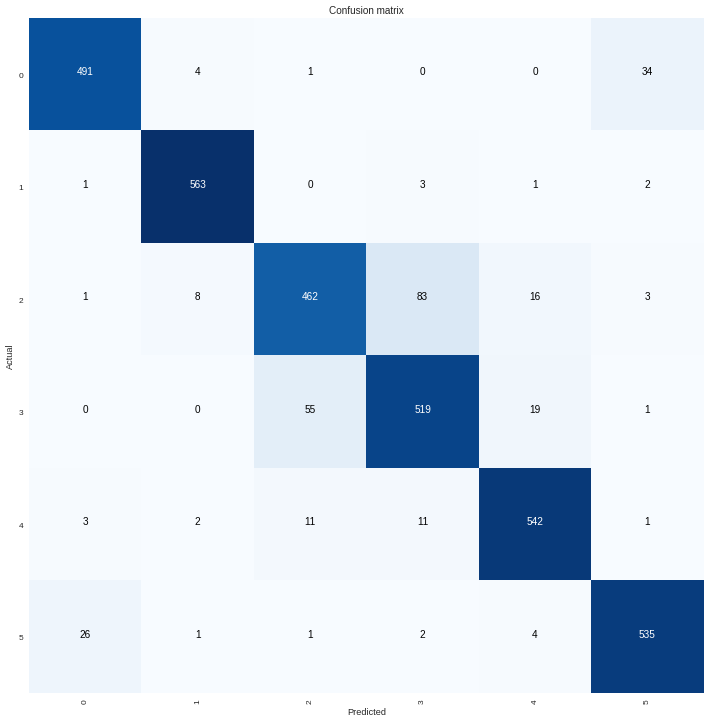

In [38]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [39]:
interp.most_confused(min_val=2)


[(2, 3, 83),
 (3, 2, 55),
 (0, 5, 34),
 (5, 0, 26),
 (3, 4, 19),
 (2, 4, 16),
 (4, 2, 11),
 (4, 3, 11),
 (2, 1, 8),
 (0, 1, 4),
 (5, 4, 4),
 (1, 3, 3),
 (2, 5, 3),
 (4, 0, 3),
 (1, 5, 2),
 (4, 1, 2),
 (5, 3, 2)]

In [0]:
learn.unfreeze()

In [41]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


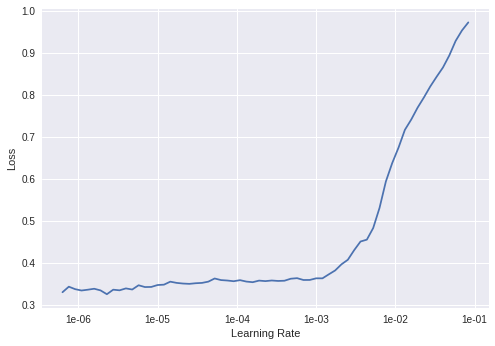

In [42]:
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(4, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.313162,0.224359,0.082208,0.917792,02:07
1,0.273012,0.210254,0.078391,0.921609,02:07
2,0.277930,0.203320,0.074574,0.925426,02:07
3,0.257972,0.203810,0.076042,0.923958,02:07


In [0]:
learn.save('/content/models/stage-2-34-128')

In [45]:
ls

adc.json     models/       train/
data-test/   sample_data/  train.csv
data-train/  test.csv      train-scene-classification.zip


In [0]:
learn.export()

In [53]:
ls

adc.json     models/       train/
data-test/   sample_data/  train.csv
data-train/  test.csv      train-scene-classification.zip


In [54]:
path = learn.path
print(path)

/content/train


In [0]:
learn = load_learner(path)

In [0]:
test = pd.read_csv('/content/test.csv')

In [0]:
images = []
prediction = []
probability = []
for i in test['image_name']:
  images.append(i)
  link = str(path)+'/'+i
  img = open_image(link)
  pred_class,pred_idx,outputs = learn.predict(img)
  prediction.append(pred_class.obj)
  probability.append(outputs.abs().max().item())
answer = pd.DataFrame({'image_name':images,'label':prediction,'probability':probability})
answer.head()
answer.to_csv('/content/submission.csv')
  

In [0]:
tfms = get_transforms(flip_vert=False,max_zoom=1.0,max_warp=0.5)
data = (ImageList.from_csv(path, csv_name = '/content/train.csv') 
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = '/content/data-test/test_imgs')              
        .transform(tfms, size=256)
        .databunch(num_workers=0)
        
       )  

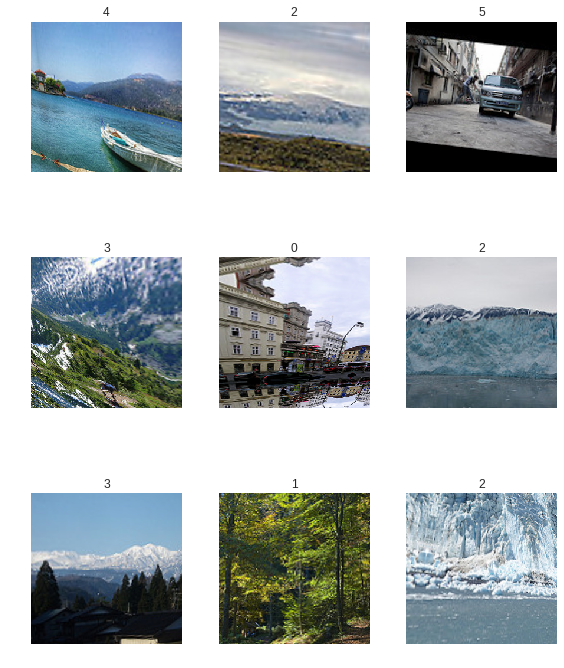

In [23]:
data.show_batch(rows=3, figsize=(8,10))

In [24]:
learn.load('/content/stage-2-34-128')

Learner(data=ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
4,5,4,1,5
Path: /content/train;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
3,1,3,2,2
Path: /content/train;

Test: LabelList (7301 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: /content/train, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, ker

In [0]:
learn.unfreeze()

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


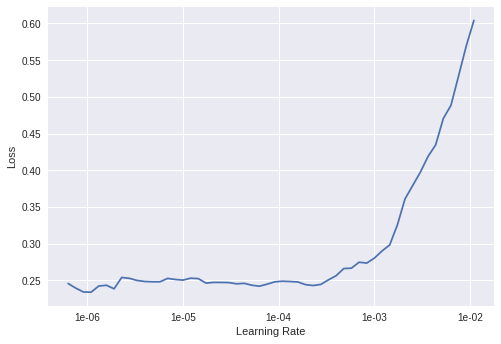

In [27]:
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(4, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.259126,0.209708,0.072519,0.927481,02:05
1,0.255745,0.204313,0.073693,0.926307,02:05
2,0.231671,0.201794,0.067528,0.932472,02:05
3,0.230863,0.200375,0.071638,0.928362,02:04


In [0]:
learn.export()

In [0]:
ls

In [0]:
learn = load_learner()